In [1]:
from torch.nn import Sequential
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

In [24]:
class CNN2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
    def forward(self,x):
        return self.network(x)

In [2]:
class CNN1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(p=0.25),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Dropout(p=0.25),

            nn.Flatten(),
            nn.Linear(128*8*8,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,10)
        )
    def forward(self,x):
        return self.network(x)

In [10]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = Sequential(
        nn.Conv2d(3, 48, 3,2,1),
        nn.ReLU(),
        nn.LocalResponseNorm(3),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(48, 96,3,2,1),
        nn.ReLU(),
        nn.LocalResponseNorm(1),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(96,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,96,3,2,1),
        nn.ReLU(),
        nn.LocalResponseNorm(1),#* mmaybe remove these rows
        nn.ReLU(),              #*
        nn.Flatten(),
        nn.Linear(96 , 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
        )
    def forward(self,x):
        return self.network(x)


In [19]:
class CNN3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(), 
            nn.Linear(128*2*2, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(1),
        )
    def forward(self,x):
        return self.network(x)

In [3]:
@torch.no_grad()
def validation_step(model: nn.Module, batch,device):
    model.eval()
    images,labels = batch[0].to(device), batch[1].to(device)
    outputs = model(images)
    loss = F.cross_entropy(outputs,labels)
    _, predicted = torch.max(outputs.data,1)
    acc = torch.tensor(torch.sum(predicted == labels).item() / len(predicted))
    return {'val_loss': loss.detach(), 'val_acc' : acc}


In [155]:
def fit(model : nn.Module,train_loader,test_loader,lr=0.001,beta=(0.9, 0.999),eps=1e-8,epochs = 10,crit_class = nn.CrossEntropyLoss,opt_class =optim.Adam ):
    criterion = crit_class()
    optimizer = opt_class(model.parameters(),lr=lr,betas=beta,eps=eps)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    history =[]
    for epoch in range(epochs):
        model.train()
        train_losses =[]

        #training phase
        for i,data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #validation phase
        outputs = [validation_step(model,batch,device) for batch in test_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        train_loss = torch.stack(train_losses).mean()
        results = {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item(), 'train_loss': train_loss.item()}
        print(f"Model[lr={lr},beta={beta},eps={eps}]Epoch [{epoch}], train_loss: {results['train_loss']:.4f}, val_loss: {results['val_loss']:.4f}, val_acc: {results['val_acc']:.4f}")
        history.append(results)
    print("Finished model training")
    return history

def eval(model:nn.Module,test_loader,device = 'cpu'):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


In [106]:
#data loading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [15]:
for lr in learning_rate:
    for beta in betas:
        for eps in epsilons:
            model = CNN2()
            history = fit(model,trainloader,testloader,lr,beta,eps,epochs=10,crit_class=nn.CrossEntropyLoss,opt_class=optim.Adam)
            PATH = f'./CNN2_models/lr={lr}_beta={beta}_eps={eps}.pth'
            torch.save(model.state_dict(),PATH)
            PATH = f'./CNN2_histories/lr={lr}_beta={beta}_eps={eps}.pt'
            torch.save(history,PATH)
            

Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [0], train_loss: 1.8454, val_loss: 1.5950, val_acc: 0.4040
Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [1], train_loss: 1.5163, val_loss: 1.4478, val_acc: 0.4662
Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [2], train_loss: 1.3959, val_loss: 1.3688, val_acc: 0.4992
Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [3], train_loss: 1.2920, val_loss: 1.2480, val_acc: 0.5505
Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [4], train_loss: 1.1949, val_loss: 1.1547, val_acc: 0.5855
Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [5], train_loss: 1.0912, val_loss: 1.0898, val_acc: 0.6127
Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [6], train_loss: 1.0037, val_loss: 1.0133, val_acc: 0.6435
Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [7], train_loss: 0.9271, val_loss: 0.9464, val_acc: 0.6644
Model[lr=0.0001,beta=(0.9, 0.9),eps=1e-08]Epoch [8], train_loss: 0.8496, val_loss: 0.8828, val_acc: 0.6897
Model[lr=0.0001,beta=(0.9, 0.9),eps=1

In [8]:
model = CNN1()
history = fit(model,trainloader,testloader)

Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [0], train_loss: 1.4239, val_loss: 0.9444, val_acc: 0.6644
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [1], train_loss: 0.9398, val_loss: 0.7443, val_acc: 0.7415
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [2], train_loss: 0.7741, val_loss: 0.6595, val_acc: 0.7689
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [3], train_loss: 0.6650, val_loss: 0.6123, val_acc: 0.7878
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [4], train_loss: 0.5751, val_loss: 0.5852, val_acc: 0.8028
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [5], train_loss: 0.4997, val_loss: 0.5546, val_acc: 0.8112
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [6], train_loss: 0.4437, val_loss: 0.5649, val_acc: 0.8116
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [7], train_loss: 0.3925, val_loss: 0.5659, val_acc: 0.8245
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [8], train_loss: 0.3494, val_loss: 0.5528, val_acc: 0.8262
Model[lr=0.001,beta=(0.9, 0.

In [11]:
model = CNN()
history = fit(model,trainloader,testloader)

Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [0], train_loss: 1.9181, val_loss: 1.7584, val_acc: 0.2826
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [1], train_loss: 1.6551, val_loss: 1.5583, val_acc: 0.3794
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [2], train_loss: 1.5112, val_loss: 1.4661, val_acc: 0.4368
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [3], train_loss: 1.3758, val_loss: 1.3336, val_acc: 0.4977
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [4], train_loss: 1.2510, val_loss: 1.2626, val_acc: 0.5310
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [5], train_loss: 1.1428, val_loss: 1.1832, val_acc: 0.5690
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [6], train_loss: 1.0476, val_loss: 1.1494, val_acc: 0.5875
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [7], train_loss: 0.9744, val_loss: 1.0718, val_acc: 0.6190
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [8], train_loss: 0.9116, val_loss: 1.1016, val_acc: 0.6127
Model[lr=0.001,beta=(0.9, 0.

In [20]:
model = CNN3()
history = fit(model,trainloader,testloader)

Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [0], train_loss: 2.1255, val_loss: 2.0387, val_acc: 0.4196
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [1], train_loss: 2.0120, val_loss: 1.9884, val_acc: 0.4679
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [2], train_loss: 1.9522, val_loss: 1.9381, val_acc: 0.5203
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [3], train_loss: 1.9146, val_loss: 1.9129, val_acc: 0.5468
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [4], train_loss: 1.8787, val_loss: 1.8723, val_acc: 0.5891
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [5], train_loss: 1.8554, val_loss: 1.8545, val_acc: 0.6074
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [6], train_loss: 1.8358, val_loss: 1.8423, val_acc: 0.6204
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [7], train_loss: 1.8142, val_loss: 1.8502, val_acc: 0.6094
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [8], train_loss: 1.7975, val_loss: 1.8383, val_acc: 0.6229
Model[lr=0.001,beta=(0.9, 0.

In [9]:
PATH = './example_models/CNN1.pth'
torch.save(model.state_dict(),PATH)
PATH = './example_models/CNN1_history.pt'
torch.save(history,PATH)

In [12]:
PATH = './example_models/CNN.pth'
torch.save(model.state_dict(),PATH)
PATH = './example_models/CNN_history.pt'
torch.save(history,PATH)

In [21]:
PATH = './example_models/CNN3.pth'
torch.save(model.state_dict(),PATH)
PATH = './example_models/CNN3_history.pt'
torch.save(history,PATH)

In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure("accuracy")
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

In [27]:
#loading the models
PATH = './example_models/CNN.pth'
model_cnn = CNN()
model_cnn.load_state_dict(torch.load(PATH))
PATH = './example_models/CNN_history.pt'
history_cnn = torch.load(PATH)
print("Finished loading CNN")

PATH = './example_models/CNN1.pth'
model_cnn1 = CNN1()
model_cnn1.load_state_dict(torch.load(PATH))
PATH = './example_models/CNN1_history.pt'
history_cnn1 = torch.load(PATH)
print("Finished loading CNN1")

PATH = './example_models/CNN2.pth'
model_cnn2 = CNN2()
model_cnn2.load_state_dict(torch.load(PATH))
PATH = './example_models/CNN2_history.pt'
history_cnn2 = torch.load(PATH)
print("Finished loading CNN2")

PATH = './example_models/CNN3.pth'
model_cnn3 = CNN3()
model_cnn3.load_state_dict(torch.load(PATH))
PATH = './example_models/CNN3_history.pt'
history_cnn3 = torch.load(PATH)
print("Finished loading CNN3")

Finished loading CNN
Finished loading CNN1
Finished loading CNN2
Finished loading CNN3


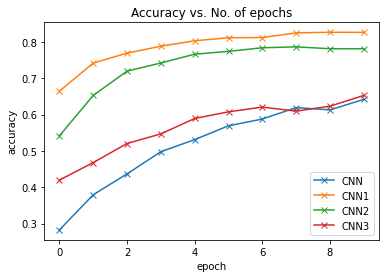

In [31]:
plot_accuracies(history_cnn)
plot_accuracies(history_cnn1)
plot_accuracies(history_cnn2)
plot_accuracies(history_cnn3)
plt.legend(["CNN","CNN1","CNN2","CNN3"])

In [42]:
# predict = model_cnn(testset.data)
y_pred = []
y_true = []
for inputs, labels in testloader:
        output = model_cnn1(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1])
        y_pred.extend(output) # Save Prediction
        
        labels = labels
        y_true.extend(labels) # Save Truth


In [75]:
str(CNN)[17:-2]
str(type(model_cnn3))[17:-2]

'CNN3'

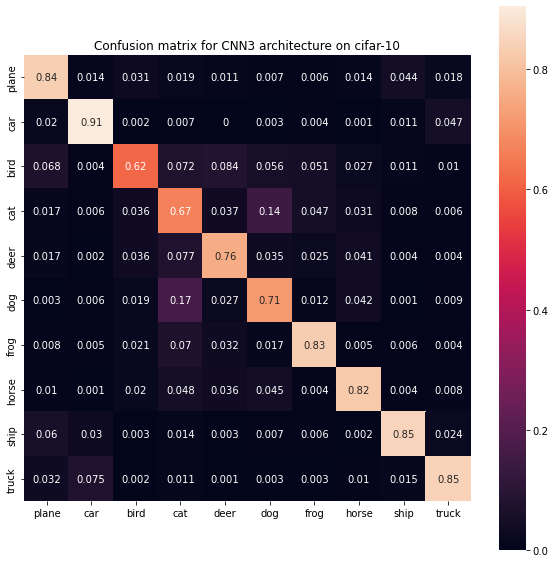

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true,y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix/1000,annot=True,xticklabels=classes,yticklabels=classes,ax=ax,square=True)
ax.set_title(f"Confusion matrix for {str(type(model_cnn3))[17:-2]} architecture on cifar-10")
plt.show()

In [79]:
def conf_matrix(model : nn.Module, test_loader):
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    #generate model predictions
    y_pred = []
    y_true = []
    for inputs,labels in test_loader:
        prediction = model(inputs)
        prediction = (torch.max(prediction.data,1))[1]
        y_pred.extend(prediction)
        y_true.extend(labels)
    
    cf_matrix = confusion_matrix(y_true,y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    heatmap(cf_matrix/1000,annot=True,xticklabels=classes,yticklabels=classes,ax=ax,square=True)
    ax.set_title(f"Confusion matrix for {str(type(model))[17:-2]} architecture on cifar-10")
    plt.show()
    return cf_matrix

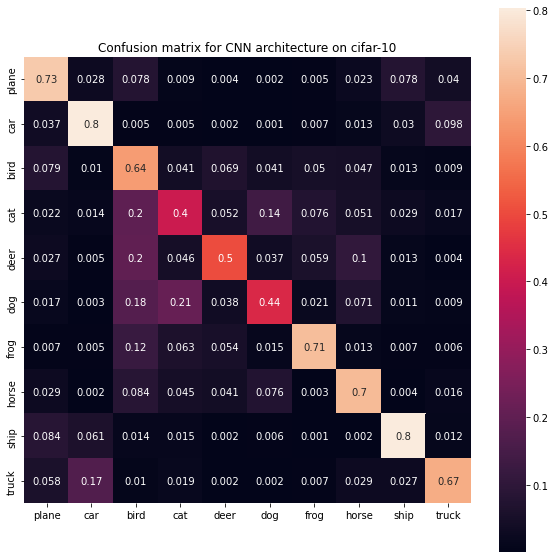

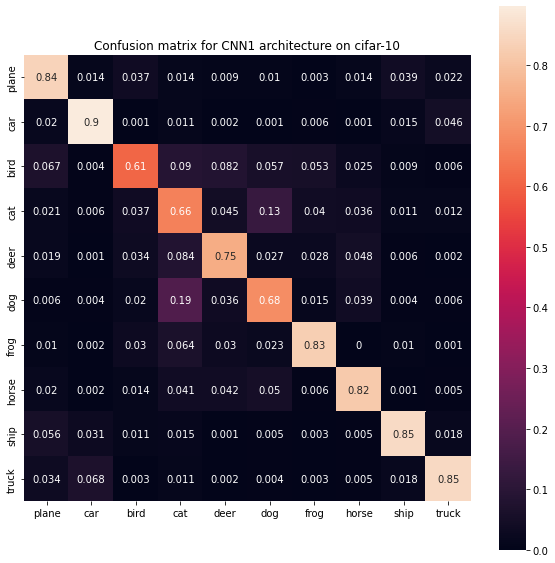

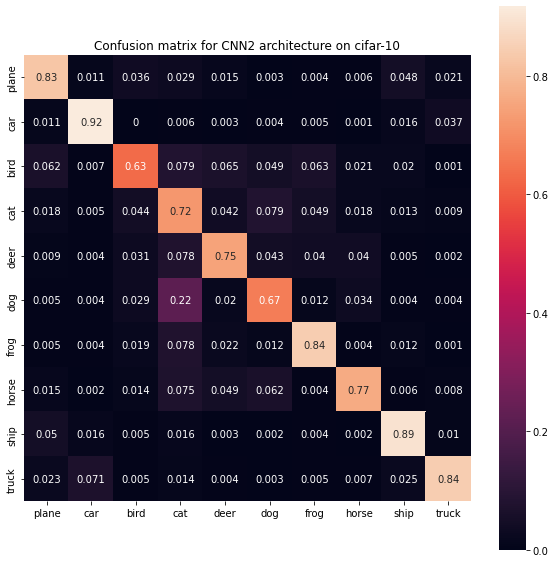

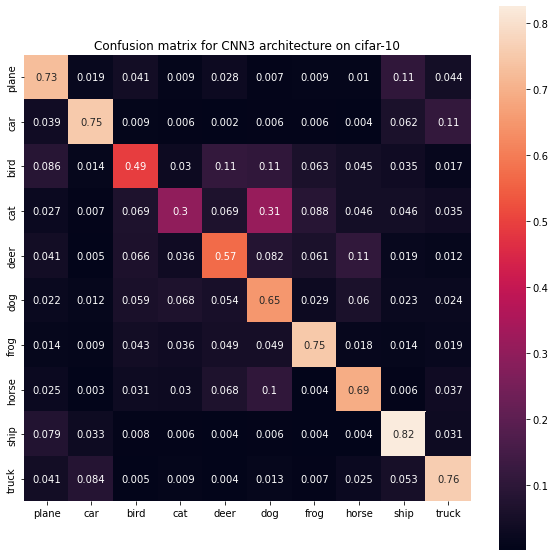

In [80]:
cfm_cnn = conf_matrix(model_cnn,testloader)
cfm_cnn1 = conf_matrix(model_cnn1,testloader)
cfm_cnn2 = conf_matrix(model_cnn2,testloader)
cfm_cnn3 = conf_matrix(model_cnn3,testloader)

In [105]:
eval(model_cnn,testloader)
eval(model_cnn1,testloader)
eval(model_cnn2,testloader)
eval(model_cnn3,testloader)

Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 78 %
Accuracy of the network on the 10000 test images: 78 %
Accuracy of the network on the 10000 test images: 65 %


In [107]:
eval(model_cnn,testloader)
eval(model_cnn1,testloader)
eval(model_cnn2,testloader)
eval(model_cnn3,testloader)

Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 77 %
Accuracy of the network on the 10000 test images: 78 %
Accuracy of the network on the 10000 test images: 65 %


In [143]:
device = "cuda"

In [164]:
class RNN(nn.Module):
    def __init__(self,hidden_dim,layer_dim,dropout = 0) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(32*32*3,hidden_dim,layer_dim,nonlinearity='relu',dropout=dropout,batch_first = True)
        self.fc = nn.Linear(hidden_dim,10)
    
    def forward(self,x):
        x = x.reshape(x.size(0),-1)
        batch_size = x.size(0)
        x = x.unsqueeze(1)
        
        
        hidden = self.init_hidden(batch_size).to(device)
        

        out, hidden = self.rnn(x, hidden)
        
        
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layer_dim, batch_size, self.hidden_dim)
        return hidden

In [157]:
@torch.no_grad()
def validation_step_rnn(model: nn.Module, batch,device):
    model.eval()
    images,labels = batch[0].to(device), batch[1].to(device)
    outputs,_ = model(images)
    loss = F.cross_entropy(outputs,labels)
    _, predicted = torch.max(outputs.data,1)
    acc = torch.tensor(torch.sum(predicted == labels).item() / len(predicted))
    return {'val_loss': loss.detach(), 'val_acc' : acc}

def fit_rnn(model : nn.Module,train_loader,test_loader,lr=0.001,beta=(0.9, 0.999),eps=1e-8,epochs = 10,crit_class = nn.CrossEntropyLoss,opt_class =optim.Adam ):
    criterion = crit_class()
    optimizer = opt_class(model.parameters(),lr=lr,betas=beta,eps=eps)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    history =[]
    for epoch in range(epochs):
        model.train()
        train_losses =[]

        #training phase
        for i,data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #validation phase
        outputs = [validation_step_rnn(model,batch,device) for batch in test_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        train_loss = torch.stack(train_losses).mean()
        results = {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item(), 'train_loss': train_loss.item()}
        print(f"Model[lr={lr},beta={beta},eps={eps}]Epoch [{epoch}], train_loss: {results['train_loss']:.4f}, val_loss: {results['val_loss']:.4f}, val_acc: {results['val_acc']:.4f}")
        history.append(results)
    print("Finished model training")
    return history


In [163]:
model_rnn = RNN(256,8)
history_rnn = fit_rnn(model_rnn,trainloader,testloader)

Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [0], train_loss: 1.8603, val_loss: 1.7030, val_acc: 0.3647
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [1], train_loss: 1.6261, val_loss: 1.5540, val_acc: 0.4452
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [2], train_loss: 1.4722, val_loss: 1.5078, val_acc: 0.4601
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [3], train_loss: 1.3680, val_loss: 1.4145, val_acc: 0.5045
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [4], train_loss: 1.2849, val_loss: 1.3890, val_acc: 0.5091
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [5], train_loss: 1.1995, val_loss: 1.3859, val_acc: 0.5152
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [6], train_loss: 1.1373, val_loss: 1.3800, val_acc: 0.5223
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [7], train_loss: 1.0715, val_loss: 1.3845, val_acc: 0.5257
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [8], train_loss: 1.0084, val_loss: 1.3910, val_acc: 0.5372
Model[lr=0.001,beta=(0.9, 0.

In [ ]:
rnn_params = [
    (16,1),
    (16,2),
    (16,4),
    (64,1),
    (64,2),
    (64,4),
    (128,1),
    (128,2),
    (128,4),
    (256,1),
    (256,2),
    (256,4),
]

In [ ]:
for hid_dim,layer_dim in rnn_params:
    model_rnn = rnn_params(hid_dim,layer_dim)
    history_rnn = fit_rnn(model_rnn,trainloader,testloader)
    PATH = f'/content/drive/MyDrive/RNN_models/hid-dim={hid_dim}_layer-dim={layer_dim}.pth'
    torch.save(model_rnn.state_dict(),PATH)
    PATH = f'/content/drive/MyDrive/RNN_histories/hid-dim={hid_dim}_layer-dim={layer_dim}.pth'
    torch.save(history_rnn,PATH)

lr=0.001_beta=(0.9, 0.95)_eps=3.97e-08.pt
{'val_loss': 0.7746257781982422, 'val_acc': 0.8067642450332642, 'train_loss': 0.17170874774456024}


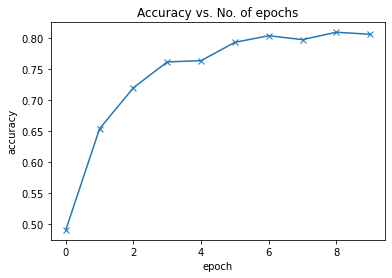

In [185]:
import os
directory = './CNN2_histories/'
histories = {}
for filename in os.listdir(directory):
    PATH = directory+filename
    histories[filename] = torch.load(PATH)
best_model_cnn2_history = max(histories,key = lambda x : histories[x][9]['val_acc'])
print(best_model_cnn2_history)
print(histories[best_model_cnn2_history][9])
best_model_cnn2 = CNN2()
best_model_cnn2.load_state_dict(torch.load('./CNN2_models/'+best_model_cnn2_history+'h'))
plot_accuracies(histories[best_model_cnn2_history])

In [190]:
best_rnn = RNN(256,2)
best_rnn.load_state_dict(torch.load('./best_models/RNN.pth'))
best_rnn.to(device)
best_rnn_history = torch.load('./best_models/RNN_history.pt')


In [195]:
with torch.no_grad():
        for inputs,labels in testloader:
            prediction = best_rnn(inputs.to(device))
            # print(prediction)
            prediction = (torch.max(prediction[0].data,1))[1]
            y_pred.extend(prediction)
            y_true.extend(labels)

In [269]:
def conf_matrix_rnn(model : nn.Module, test_loader):
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    #generate model predictions
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs = inputs.to(device)
            predictions,_ = model(inputs)
            _, predictions = torch.max(predictions.data,1)
            y_pred.extend(predictions.data.tolist())
            y_true.extend(labels.tolist())

            
    cf_matrix = confusion_matrix(y_true,y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    heatmap(cf_matrix/1000,annot=True,xticklabels=classes,yticklabels=classes,ax=ax,square=True)
    ax.set_title(f"Confusion matrix for {str(type(model))[17:-2]} architecture on cifar-10")
    plt.show()
    return cf_matrix

In [261]:
temp = torch.Tensor([1]).to(device)
temp.data[0]

tensor(1., device='cuda:0')

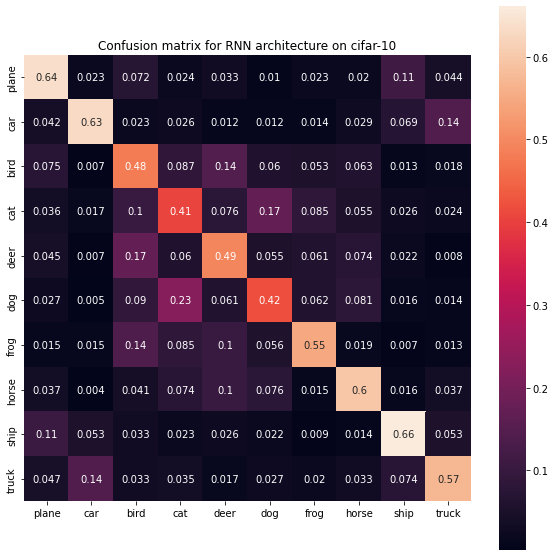

In [271]:
cfm_rnn = conf_matrix_rnn(best_rnn,testloader)

In [279]:
def save_best_model(arch:nn.Module):
    histories = {}
    arch_name = str(arch)[17:-2]
    directory = f'./{arch_name}_histories/'
    for filename in os.listdir(directory):
        PATH = directory+filename
        histories[filename] = torch.load(PATH)
    best_model_history = max(histories,key = lambda x : histories[x][9]['val_acc'])

    print(best_model_history)
    print(histories[best_model_history][9])
    model = arch()
    model.load_state_dict(torch.load(f'./{arch_name}_models/'+best_model_history+'h'))
    
    PATH = './best_models/'+arch_name+'.pth'
    torch.save(model.state_dict(),PATH)
    PATH = './best_models/'+arch_name+'_history.pt'
    torch.save(histories[best_model_history],PATH)


In [280]:
save_best_model(CNN1)

lr=0.0003_beta=(0.8, 0.999)_eps=1e-08.pt
{'val_loss': 0.5215855240821838, 'val_acc': 0.8331685066223145, 'train_loss': 0.23327086865901947}


In [281]:
PATH = './best_models/CNN1.pth'
model_cnn1 = CNN1()
model_cnn1.load_state_dict(torch.load(PATH))
PATH = './best_models/CNN1_history.pt'
history_cnn1 = torch.load(PATH)
print("Finished loading CNN1")

Finished loading CNN1


In [ ]:
model_cnn = CNN()
fit(model_cnn,trainloader,testloader)

In [287]:
def plot_metric(history,metric = 'val_acc'):
    metrics = [x[metric] for x in history]
    plt.figure("metric "+metric)
    plt.plot(metrics, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'{metric} vs. No. of epochs')

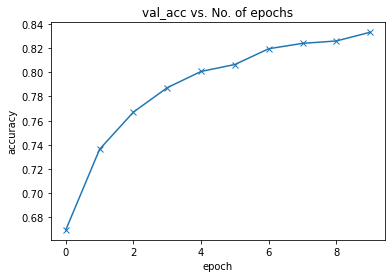

In [288]:
plot_metric(history_cnn1,metric='val_acc')

In [298]:
learning_rate = [0.001,0.003]
betas = [(0.9,0.999),(0.8,0.999),(0.9,0.95),(0.95,0.999)]
epsilons = [1e-8,3e-8]
print(len(betas),len(epsilons),len(learning_rate))
print(len(betas)*len(epsilons)*len(learning_rate))

4 2 2
16


In [299]:
for lr in learning_rate:
    for beta in betas:
        for eps in epsilons:
            model = CNN()
            history = fit(model,trainloader,testloader,lr,beta,eps,epochs=10,crit_class=nn.CrossEntropyLoss,opt_class=optim.Adam)
            PATH = f'./CNN_models/lr={lr}_beta={beta}_eps={eps}.pth'
            torch.save(model.state_dict(),PATH)
            PATH = f'./CNN_histories/lr={lr}_beta={beta}_eps={eps}.pt'
            torch.save(history,PATH)